# Energy Based LNN - Dataset Exploration for EDA

In training the energy based LNN, a comprehensive dataset covering all scenarios and conditions of the problem domain must be available. However, that requires a collection of data spanning multiple years which introduce multiple issues during data collection and historical context understanding. Typically, in a refinery, although the data retention spans to more than 10 years, the people memory associated with the data does not necessarily retains that long. This causes issues as the data collected must be provided with historical context to allow for better understanding of the data trend.

To resolve this issues, we propose usage of PINN (Physics Informed Neural Network) train on a subset of data to create a complete model of our problem domain. Once PINN has been proven effective and matched the data accuracy, we will use PINN as data generator to generate comprehensive dataset needed for our energy based model training.

## The Problem Domain

The domain problem here refers to an industrial furnace in a petrochemical industry. The furnace can be modeled using simple thermodynamic equation that can be written simply as below:

$$Q = mC_p\Delta T $$

where $Q$ represents the amount of heat, $m$ is the mass flow of the medium carrying the heat, and $C_p$ represents the specific heat capacity of the medium.

We have to imagine a furnace as a system, where the input entering the furnace at initial temperature, $T_1$ will be heated up from the combustion inside the furnace. Then we can measure the outlet temperature, $T_2$. The difference between $T_1$ and $T_2$ is written as $ \Delta T$.

To accurately model the furnace, the equation above can be written as 

$$\dot{Q}_{absorbed} = \dot{m} C_p (T_{out} - T_{in})$$

where the dot there indicate it as a rate, and the heat means rate of heat absorbed.

This data is taken from a refinery in Malaysia. For the sake of data confidentiality, the details of the refinery will not be shared. We will keep the only required information here which is crucial to model the furnace.

The furnace is a Vertical Cylindrical (VC), natural-draft heater designed to preheat a liquid hydrocarbon feed prior to a reactor unit. The unit operates with a design duty of 10.41 MW. It consists of a radiant section with vertical tubes and a convection section with horizontal tube banks (shock and shield coils). The combustion system utilizes a clean natural gas fuel source, controlled to maintain the target outlet temperature ($T_{out}$) required for the downstream reaction kinetics.


### Modeling Assumptions


To formulate the Physics-Informed energy balance for this system, we abstract the complex 3D geometry into a Zero-Dimensional (0D) Lumped Parameter Model. This simplification balances computational efficiency with physical fidelity, governed by the following constraints:

**Lumped Control Volume**: The entire heater coil (Radiant + Convection) is modeled as a single thermodynamic control volume. Spatial variations in heat flux and temperature gradients are averaged over the effective tube length.

**Single Firing Element**: The combustion zone is treated as a uniform aggregate heat source. Individual burner configuration effects are neglected in favor of total enthalpy input derived from the fuel gas flow.

**Single-Phase Incompressible Flow**: The process fluid is modeled as a liquid phase only. We assume the operating pressure is sufficient to suppress bulk vaporization (boiling) within the tubes, treating the system strictly as a sensible heat exchanger.

**Piecewise Constant Fluid Properties**: To account for feedstock variability, density ($\rho$) and specific heat capacity ($C_p$) are treated as piecewise constants specific to the operating mode (Light, Medium, Heavy), derived from empirical laboratory data rather than static design sheets.

**Thermal Stability (No Cracking)**: Based on the unit’s operational history (no mechanical pigging required in >10 years), we assume the fluid temperature remains below the thermal cracking threshold. Endothermic reaction kinetics inside the heater tubes are therefore neglected.

**Constant Fuel Quality**: The unit is fired by commercial pipeline-grade natural gas. The Lower Heating Value (LHV) is assumed constant at 47.14 MJ/kg, with minor compositional fluctuations implicitly absorbed by the learned efficiency parameter ($\eta$).


### Clarifying the Process

The process involved in the problem domain is quite complex. It has three different fluid medium into the furnace, with varying properties. The design properties for these medium are provided in the designed document. However, it is imperative that the properties are determined using latest empirical data. Here we have the 2 years empirical data for all of our feedstock. Let's do some analysis and determine the quality for each of the feedstock.

In [1]:
#load the data first
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df_sg = pd.read_excel('DensityTrend.xlsx',sheet_name = 'Density')
df_sg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         731 non-null    datetime64[ns]
 1   FeedDensity  731 non-null    float64       
 2   LBOKV        731 non-null    float64       
 3   Mode         731 non-null    object        
 4   Unnamed: 4   0 non-null      float64       
 5   Unnamed: 5   1 non-null      object        
 6   100D         1 non-null      float64       
 7   150D         1 non-null      float64       
 8   500D         1 non-null      float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 51.5+ KB


In [2]:
#remove unwanted columns

df_sg = df_sg.drop(['100D','150D','500D','Unnamed: 4','Unnamed: 5'],axis=1)
df_sg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         731 non-null    datetime64[ns]
 1   FeedDensity  731 non-null    float64       
 2   LBOKV        731 non-null    float64       
 3   Mode         731 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 23.0+ KB


In [3]:
#let's filter based on each mode

df_100 = df_sg[df_sg['Mode'] == '100D']
df_150 = df_sg[df_sg['Mode'] == '150D']
df_500 = df_sg[df_sg['Mode'] == '500D']

In [4]:
#let's use describe on each mode

df_100.describe()

,Date,FeedDensity,LBOKV
count,428,428.000000,428.000000
mean,2024-12-08 21:13:09.569542144,0.863882,4.194541
min,2023-12-17 14:19:19.663000,0.818825,2.813797
25%,2024-05-25 08:19:19.663000064,0.858300,4.137327
50%,2024-12-06 02:19:19.663000064,0.860238,4.172984
75%,2025-06-24 14:19:19.663000064,0.862800,4.234772
max,2025-12-16 14:19:19.663000,0.906700,4.889010
std,NaN,0.011213,0.123519


In [5]:
df_150.describe()

,Date,FeedDensity,LBOKV
count,177,177.000000,177.000000
mean,2024-12-29 00:13:13.561304832,0.869483,6.295092
min,2023-12-26 14:19:19.663000,0.848200,5.086404
25%,2024-07-27 14:19:19.663000064,0.863362,6.064095
50%,2025-01-07 14:19:19.663000064,0.870100,6.186166
75%,2025-05-28 14:19:19.663000064,0.874700,6.326252
max,2025-12-12 14:19:19.663000,0.897300,8.736181
std,NaN,0.008305,0.565900


In [6]:
df_500.describe()

,Date,FeedDensity,LBOKV
count,126,126.000000,126.000000
mean,2024-12-25 08:36:28.234429184,0.882364,21.355163
min,2023-12-27 14:19:19.663000,0.795800,9.756583
25%,2024-07-04 20:19:19.663000064,0.874500,10.201941
50%,2024-12-15 14:19:19.663000064,0.881393,10.441293
75%,2025-06-24 02:19:19.663000064,0.893350,10.664259
max,2025-12-15 14:19:19.663000,0.902700,1379.409857
std,NaN,0.013034,121.953959


From here, we can correctly use the empirical value for all three feed types. Which is listed as below

1. 100D = 0.863
2. 150D = 0.869
3. 500D = 0.882

Using this value of density, we can effectively provide the $C_p$ value for all our feedstock.

### Understanding the Sensor Data

To effectively model the furnace, we need to bring in all the sensor data. 4 years historical data is collected from 5 sensors. This data will be fed into PINN modelling to ensure the thermodynamic model will be as close as possible to the real furnace condition.

So, let's first load the data

In [7]:
#load the data
df = pd.read_excel('MainData.xlsx', sheet_name = 'Main')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        35064 non-null  int64  
 1   InletT-1    35064 non-null  object 
 2   InletT-2    35064 non-null  object 
 3   InletT-Avg  34771 non-null  float64
 4   OutletT     35064 non-null  object 
 5   InletFlow   35064 non-null  object 
 6   FGFlow      35064 non-null  float64
 7   AmbientT    35064 non-null  object 
 8   ExcessO2    35064 non-null  object 
 9   KV100       35064 non-null  float64
 10  DraftP      35064 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 2.9+ MB


As shown here, we have 9 a dataset with 11 columns. The date column is actually has been indexed to ensure that the historical dates here are not shown due to issues with data confidentiality. The furnace has two passess, that is why we have inlet T-1 and inlet T-2. We can average both of these transmitter data passes, that is where the InletT-Avg comes in, which I think should be done in python, not excel. Oh well, we can come back to that later.

At the same time we also have inlet flow, which determines how much fluid are entering the furnace. FGFlow, which indicates how much fuel gas we are burning, ambient temperature, excess oxygen and draft pressure. At the same time, we also have KV100, which is an empirical lab result for the fluid, which indicates what kind of feed are we processing. We will be using it later during preprocessing.

Right now, we want to determine which method is the best way to clean up our dataset. As you can see above, a lot of our dataset are in object data type, means it contains both strings and numbers, which is not optimum for our data analysis. So, I would like to try one thing here.

In [8]:
#let's force inlet flow to be numeric

df['InletFlow'] = pd.to_numeric(df['InletFlow'],errors='coerce')

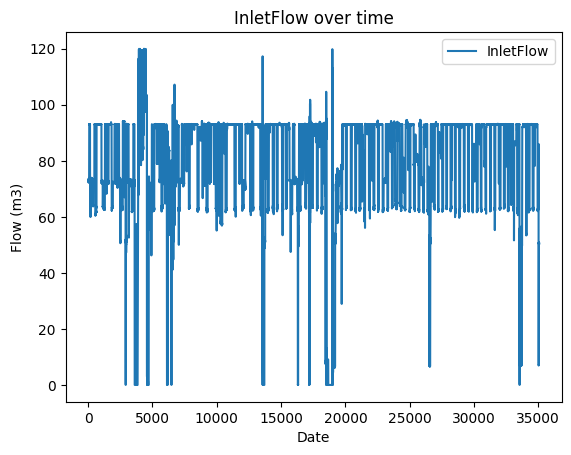

In [9]:
#alright, let us understand our data a little bit...
df.plot(x='Date', y='InletFlow', kind='line')

plt.title("InletFlow over time")
plt.ylabel("Flow (m3)")
plt.show()

The column cleanup done above is done on df['InletFlow'] which is taken from the plant inlet flow transmitter. The inlet flow transmitter on the plant determines how much fluid are entering into the plant at certain period, denoted with the unit m3/hr. It is a really good indicator for engineers to determine the unit conditions. If the plant are operating at less than turndown ratio of the plant (which in this case, 50 m3/hr), it is an indication that the unit is under shutdown condition.But it is also an indication that the unit is on shutdown. Based on the graph above, we can see that there's a few instances where the unit is under shutdown conditions, which explains the null.

Cleaning it up by forcing it to be numeric seems to work to our end. We can do this for all the columns

In [10]:
#alright...i think it's safe to clean all columns like this

cols_to_clean = ['InletT-1','InletT-2','OutletT','AmbientT','ExcessO2','KV100','DraftP']

for col in cols_to_clean:
    df[col] = pd.to_numeric(df[col], errors = 'coerce')


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        35064 non-null  int64  
 1   InletT-1    25165 non-null  float64
 2   InletT-2    34771 non-null  float64
 3   InletT-Avg  34771 non-null  float64
 4   OutletT     34771 non-null  float64
 5   InletFlow   34836 non-null  float64
 6   FGFlow      35064 non-null  float64
 7   AmbientT    34756 non-null  float64
 8   ExcessO2    34632 non-null  float64
 9   KV100       35064 non-null  float64
 10  DraftP      13338 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 2.9 MB


We have to be very carefull here. Not all null can be identified as shutdown condition. Some might also be related to transmitter issues, or disturbance. Fortunately, we have a good engineering check that we can use here to verify whether it is really a shutdown condition, or it is a transmitter issues, or signal issues. 

If the plant are really in shutdown condition, both the inlet flow and outlet temperature of the furnace will be at low condition, indicating that there's no need to heat up the furnace since we're not producing anythins. Therefore, we can implement this enginering check to our dataset.

If unit is under shutdown condition, we remove the data. If it's not, we forward fill the remaining data.

In [11]:

TURNDOWN_LIMIT = 20  #if the unit is running below 20 m3/hr, it is effectively on shutdown
REACTIVE_TEMP = 100    #if outlet temperature is below 100 degC, it is effectively on shutdown

is_running = (df['InletFlow'] > TURNDOWN_LIMIT) & (df['OutletT'] > REACTIVE_TEMP)

df_clean = df[is_running].copy()

print(f"Removed {len(df) - len(df_clean)} rows due to Shutdown/Low Load.")


df_clean = df_clean.interpolate(method='linear', limit=2)

df_final = df_clean.dropna()

Removed 2306 rows due to Shutdown/Low Load.


In [12]:
# 4. Final Safety Drop
# If a sensor was dead for > 2 hours (limit=2), interpolate won't fix it. 
# We must drop those remaining few rows to avoid crashing the model.
df_final = df_clean.dropna()
df_final = df_final.reset_index(drop =True)
df_final

,Date,InletT-1,InletT-2,InletT-Avg,OutletT,InletFlow,FGFlow,AmbientT,ExcessO2,KV100,DraftP
0,26,287.597930,282.636363,285.117146,380.048279,73.238475,810.030479,29.748699,1.530169,4.090000,-19.109134
1,27,287.725254,282.749077,285.237166,379.992428,72.985013,808.405539,29.935679,1.514413,4.090000,-18.671751
2,28,287.873223,282.899439,285.386331,380.026249,72.820158,808.960339,29.902503,1.504156,4.090000,-19.453460
3,29,287.976527,282.939280,285.457904,380.006511,72.734598,807.120457,29.549360,1.500231,4.078894,-19.192650
4,30,287.646674,282.540383,285.093528,379.993505,72.692551,809.664227,29.510496,1.500805,4.078000,-18.931841
...,...,...,...,...,...,...,...,...,...,...,...
11559,35060,298.872144,297.785886,298.329015,381.955200,50.141740,690.772676,27.160714,5.003186,4.399000,-8.507136
11560,35061,298.702562,297.657904,298.180233,382.025583,50.135946,689.447528,26.944168,1.816461,4.399000,-8.471063
11561,35062,298.598672,297.573539,298.086105,381.974389,50.351476,689.668902,26.823625,2.565153,4.399000,-8.444568
11562,35063,298.704716,297.827802,298.266259,382.032729,50.557355,687.763401,27.051063,5.802843,4.399000,-8.364948


In [13]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11564 entries, 0 to 11563
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        11564 non-null  int64  
 1   InletT-1    11564 non-null  float64
 2   InletT-2    11564 non-null  float64
 3   InletT-Avg  11564 non-null  float64
 4   OutletT     11564 non-null  float64
 5   InletFlow   11564 non-null  float64
 6   FGFlow      11564 non-null  float64
 7   AmbientT    11564 non-null  float64
 8   ExcessO2    11564 non-null  float64
 9   KV100       11564 non-null  float64
 10  DraftP      11564 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 993.9 KB


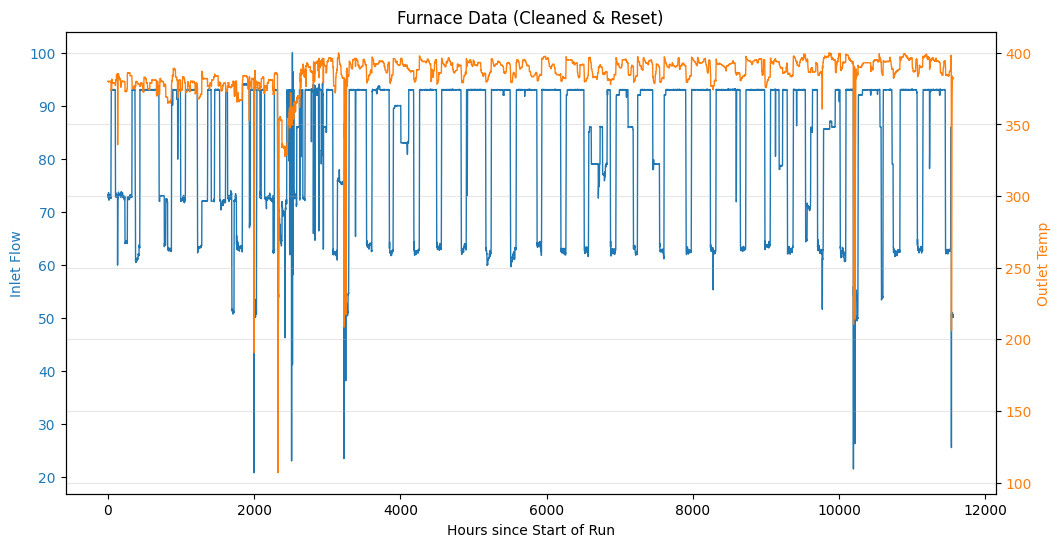

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

df_final['Date'] = df_final.index


fig, ax1 = plt.subplots(figsize=(12, 6))

color_flow = 'tab:blue'
ax1.set_xlabel('Hours since Start of Run')  # Updated Label
ax1.set_ylabel('Inlet Flow', color=color_flow)
ax1.plot(df_final['Date'], df_final['InletFlow'], color=color_flow, linewidth=1)
ax1.tick_params(axis='y', labelcolor=color_flow)

ax2 = ax1.twinx()
color_temp = 'tab:orange'
ax2.set_ylabel('Outlet Temp', color=color_temp)
ax2.plot(df_final['Date'], df_final['OutletT'], color=color_temp, linewidth=1)
ax2.tick_params(axis='y', labelcolor=color_temp)

plt.title('Furnace Data (Cleaned & Reset)')
plt.grid(True, alpha=0.3)
plt.show()

Alright. The data looks good. We have than 10,000 hrs of data, which I think is more than enough to train the model. But, we have to add one more features, which is the specific heat capacity, $C_p$. This can be determined via density data that we have above. For this ,we will use the KV100 columns as indicator. We will set few logical rules for the KV100 to determine which mode of processing we are currently doing.

There are three modes of operation,

1. 100D mode
2. 150D mode
3. 500D mode

The conditions to determine each mode are shown as below

If KV100 < 6 , 100D mode, <9, 150D mode, >9, 500D mode.
So let's implement that below

In [15]:
conditions = [
    (df_final['KV100'] < 6),
    (df_final['KV100'] < 9),
    (df_final['KV100'] > 9)
]

#define the values we want to asign
choices = ['0.863', '0.869', '0.882']

df_final['Density'] = np.select(conditions, choices, default='0.863')

In [16]:
df_final['Density'] = pd.to_numeric(df_final['Density'], errors ='coerce')

In [17]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11564 entries, 0 to 11563
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        11564 non-null  int64  
 1   InletT-1    11564 non-null  float64
 2   InletT-2    11564 non-null  float64
 3   InletT-Avg  11564 non-null  float64
 4   OutletT     11564 non-null  float64
 5   InletFlow   11564 non-null  float64
 6   FGFlow      11564 non-null  float64
 7   AmbientT    11564 non-null  float64
 8   ExcessO2    11564 non-null  float64
 9   KV100       11564 non-null  float64
 10  DraftP      11564 non-null  float64
 11  Density     11564 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 1.1 MB


Let's do the final adjustment to our data. Since we're doing the InletT-Avg inside excel, it might have issues during our preprocessing above. Maybe the value does not tally with InletT-1 and InletT-2. I believe, we need to do this entirely in python.

In [18]:
df_final['InletT-Avg'] = (df_final['InletT-1'] + df_final['InletT-2']) / 2
# 2. Remove the individual sensor columns InletT-1 and InletT-2
df_final = df_final.drop(columns=['InletT-1', 'InletT-2','KV100'])

df_final

,Date,InletT-Avg,OutletT,InletFlow,FGFlow,AmbientT,ExcessO2,DraftP,Density
0,0,285.117146,380.048279,73.238475,810.030479,29.748699,1.530169,-19.109134,0.863
1,1,285.237166,379.992428,72.985013,808.405539,29.935679,1.514413,-18.671751,0.863
2,2,285.386331,380.026249,72.820158,808.960339,29.902503,1.504156,-19.453460,0.863
3,3,285.457904,380.006511,72.734598,807.120457,29.549360,1.500231,-19.192650,0.863
4,4,285.093528,379.993505,72.692551,809.664227,29.510496,1.500805,-18.931841,0.863
...,...,...,...,...,...,...,...,...,...
11559,11559,298.329015,381.955200,50.141740,690.772676,27.160714,5.003186,-8.507136,0.863
11560,11560,298.180233,382.025583,50.135946,689.447528,26.944168,1.816461,-8.471063,0.863
11561,11561,298.086105,381.974389,50.351476,689.668902,26.823625,2.565153,-8.444568,0.863
11562,11562,298.266259,382.032729,50.557355,687.763401,27.051063,5.802843,-8.364948,0.863


In [19]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11564 entries, 0 to 11563
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        11564 non-null  int64  
 1   InletT-Avg  11564 non-null  float64
 2   OutletT     11564 non-null  float64
 3   InletFlow   11564 non-null  float64
 4   FGFlow      11564 non-null  float64
 5   AmbientT    11564 non-null  float64
 6   ExcessO2    11564 non-null  float64
 7   DraftP      11564 non-null  float64
 8   Density     11564 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 813.2 KB


### The Thermodynamic Energy Balance for PINN

The fundamental governing equation for the furnace is based on the First Law of Thermodynamics (Conservation of Energy). We model the system as a steady-state control volume where the heat released by combustion (scaled by efficiency) must equal the heat absorbed by the process fluid.
$$Q_{combustion} \cdot \eta \approx Q_{process}$$

Expanding this into measurable variables:

$$(\dot{m}_{fuel} \cdot LHV) \cdot \eta \approx \dot{m}_{process} \cdot C_{p,process} \cdot (T_{out} - T_{in})$$

**Derivation and Approximation of Terms**

Here is how we derived each term in the equation above using our specific industrial dataset and empirical constants:


1. $\dot{m}_{fuel}$  (Mass Flow of Fuel):
   Source: Our sensor provides FGFlow in Volumetric units ($m^3/h$).

   Conversion: 
   We convert this to Mass Flow ($kg/h$) using the standard density of Methane at STP.Value: 
   $\rho_{fuel} \approx 0.657 \, kg/m^3$.$$\dot{m}_{fuel} = \text{FGFlow} \times 0.657$$

2. $LHV$ (Lower Heating Value):

    Source: Based on the purchase of high-purity Standard Methane.Value: Fixed empirically at $50,000 \, kJ/kg$.

3. $\dot{m}_{process}$ (Mass Flow of Feedstock):

   Source: Our sensor provides InletFlow in Volumetric units ($m^3/h$).
   Conversion: We approximate Mass Flow using the average density of the crude/feedstock. While the specific gravity varies slightly (0.86–0.88), we use a representative mean for the energy balance to maintain stability.Value:

   $\rho_{process} \approx 850 \, kg/m^3$.

$$\dot{m}_{process} = \text{InletFlow} \times 850$$

4. $C_{p,process}$ (Specific Heat Capacity):
  Source: This is an empirical approximation for the crude oil/feedstock blend processed by the unit.
  Value: Fixed at $2.5 \, kJ/kg \cdot K$.Note: The learnable efficiency parameter ($\eta$) will naturally adjust to compensate if this constant varies slightly in reality.

5. $\eta$ (Thermal Efficiency):
   Source: Learned Parameter.This is not a fixed constant. The PINN learns this value (typically between 0.80 and 0.90) to minimize the error between the calculated fuel input and the observed temperature rise.

### The Stoichiometry & Mass Balance Equation for PINN

To validate the combustion quality, we simultaneously solve the Mass Balance for Oxygen. We assume the fuel is Methane ($CH_4$).

**The Reaction:**
$$CH_4 + 2O_2 \rightarrow CO_2 + 2H_2O$$

**The Equation for Air Flow:**

We do not have a direct Air Flow meter. Instead, we infer air flow from the Draft Pressure ($P_{draft}$) using the physics of fluid flow through an orifice (the damper/burner throat):

$$\dot{m}_{air} = k \cdot \sqrt{|P_{draft}|}$$

**Known Parts (The Constants):**

1. Stoichiometric Ratio ($AFR_{st}$):

We know from chemistry that Methane requires exactly 17.2 kg of Air to burn 1 kg of Fuel.

2. Target $O_2$:
   We have the ground truth from the ExcessO2 analyzer.

**Learned Parts (The Unknowns):**

1. Leakage Coefficient ($k$):
   The PINN must learn this variable. It represents the "open area" of the dampers and the amount of tramp air leaking into the box.

2. Final Constraint:The PINN calculates the Air-Fuel Equivalence Ratio ($\lambda$) and penalizes the error between the predicted Oxygen and the actual Oxygen:

   $$\lambda = \frac{\dot{m}_{air}}{\dot{m}_{fuel} \cdot 17.2}$$

   $$O_{2,predicted} \approx 21 \cdot \frac{\lambda - 1}{\lambda}$$


In [20]:
df_final.to_csv('final_data.csv',index=False)